# Dutch Plates

In [4]:
import calendar
print(calendar.month(2024,1))

    January 2024
Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7
 8  9 10 11 12 13 14
15 16 17 18 19 20 21
22 23 24 25 26 27 28
29 30 31



In [9]:
print(list(calendar.day_name))

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [20]:
import datetime
print(datetime.date(2024,1,14) - datetime.date(2024,1,17))

-3 days, 0:00:00


In [1]:
%matplotlib inline

In [2]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [3]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [21]:
import cv2
import numpy as np
import os
import pathlib
import pytesseract
%matplotlib inline
import matplotlib.pyplot as plt



def detect(img_rgb):

    img = img_rgb.copy()
    input_height = img_rgb.shape[0]
    input_width = img_rgb.shape[1]
    hsv_frame = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)

    # yellow color
    low_yellow = np.array([20, 100, 100])
    high_yellow = np.array([30, 255, 255])
    yellow_mask = cv2.inRange(hsv_frame, low_yellow, high_yellow)
    yellow = cv2.bitwise_and(yellow_mask, yellow_mask, mask=yellow_mask)

    # plt.imshow(yellow)
    # plt.title('Yellow Color')
    # cv2.imwrite("temp/steps/1_yellow_color_detection.png", yellow)
    
    # Close morph
    k = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(yellow, cv2.MORPH_CLOSE, k)

    # plt.imshow(closing)
    # plt.title('Morphing')
    # cv2.imwrite("temp/steps/2_closing_morphology.png", closing)
    
    # Detect yellow area
    # contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(yellow, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # List of final crops
    crops = []

    # Loop over contours and find license plates
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Conditions on crops dimensions and area
        if h*6 > w > 2 * h and h > 0.1 * w and w * h > input_height * input_width * 0.0001:

            # Make a crop from the RGB image, the crop is slided a bit at left to detect bleu area
            crop_img = img_rgb[y:y + h, x-round(w/10):x]
            crop_img = crop_img.astype('uint8')

            # Compute bleu color density at the left of the crop
            # Bleu color condition
            try:
                hsv_frame = cv2.cvtColor(crop_img, cv2.COLOR_BGR2HSV)
                low_bleu = np.array([100,150,0])
                high_bleu = np.array([140,255,255])
                bleu_mask = cv2.inRange(hsv_frame, low_bleu, high_bleu)
                bleu_summation = bleu_mask.sum()

            except:
                bleu_summation = 0

            # Condition on bleu color density at the left of the crop
            if bleu_summation > 550:

                # Compute yellow color density in the crop
                # Make a crop from the RGB image
                imgray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
                crop_img_yellow = img_rgb[y:y + h, x:x+w]
                crop_img_yellow = crop_img_yellow.astype('uint8')

                # Detect yellow color
                hsv_frame = cv2.cvtColor(crop_img_yellow, cv2.COLOR_BGR2HSV)
                # plt.imshow(hsv_frame)
                low_yellow = np.array([20, 100, 100])
                high_yellow = np.array([30, 255, 255])
                yellow_mask = cv2.inRange(hsv_frame, low_yellow, high_yellow)

                # Compute yellow density
                yellow_summation = yellow_mask.sum()

                # Condition on yellow color density in the crop
                if yellow_summation > 255*crop_img.shape[0]*crop_img.shape[0]*0.4:

                    # Make a crop from the gray image
                    crop_gray = imgray[y:y + h, x:x + w]
                    crop_gray = crop_gray.astype('uint8')

                    # Detect chars inside yellow crop with specefic dimension and area
                    th = cv2.adaptiveThreshold(crop_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
                    contours2, hierarchy = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                    # Init number of chars
                    chars = 0
                    for c in contours2:
                        area2 = cv2.contourArea(c)
                        x2, y2, w2, h2 = cv2.boundingRect(c)
                        if w2 * h2 > h * w * 0.01 and h2 > w2 and area2 < h * w * 0.9:
                            chars += 1

                    # Condition on the number of chars
                    if 20 > chars > 4:
                        rect = cv2.minAreaRect(cnt)
                        box = cv2.boxPoints(rect)
                        box = np.intp(box)
                        pts = np.array(box)
                        warped = four_point_transform(img, pts)
                        crops.append(warped)

                        # Using cv2.putText() method
                        img_rgb = cv2.putText(img_rgb, 'LP', (x, y), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 0, 255), 2, cv2.LINE_AA)

                        cv2.drawContours(img_rgb, [box], 0, (0, 0, 255), 2)

    return img_rgb, crops

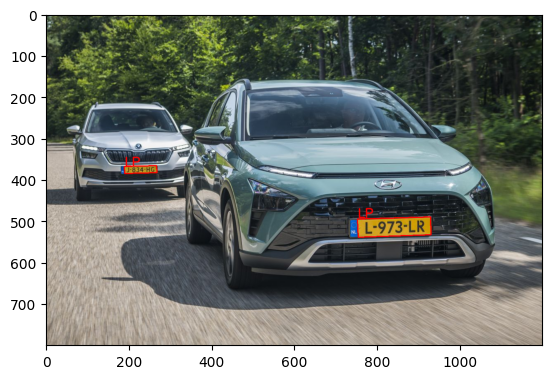

In [22]:
input_image = cv2.imread('/home/appy1/Downloads/dut5.jpg')
detection, crops = detect(input_image)
plt.imshow(cv2.cvtColor(detection, cv2.COLOR_BGR2RGB))
plt.show()

# cv2.imshow('detection', detection)
# cv2.waitKey(0)
# cv2.destroyWindow('detection')

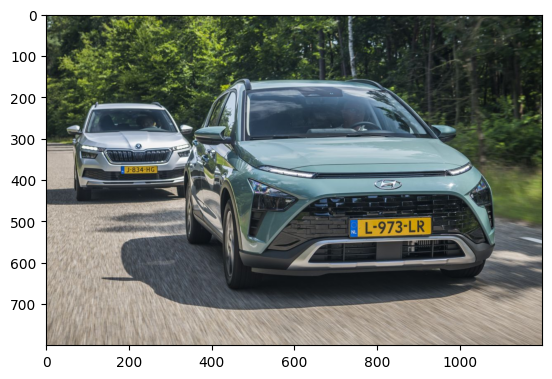

Text(0.5, 1.0, 'Yellow Color')

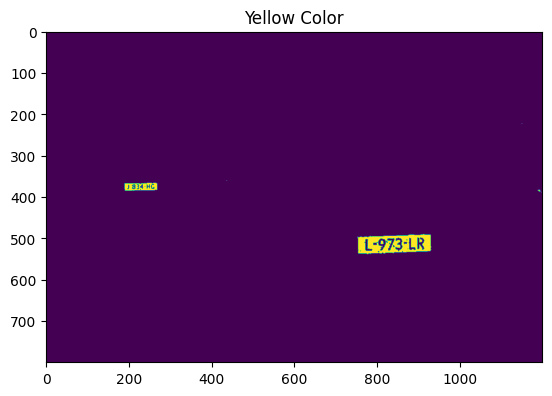

In [23]:
import cv2
import matplotlib.pyplot as plt

img_rgb = cv2.imread('/home/appy1/Downloads/dut5.jpg')
img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

input_height = img_rgb.shape[0]
input_width = img_rgb.shape[1]
hsv_frame = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)

# yellow color
low_yellow = np.array([20, 100, 100])
high_yellow = np.array([30, 255, 255])
yellow_mask = cv2.inRange(hsv_frame, low_yellow, high_yellow)
yellow = cv2.bitwise_and(yellow_mask, yellow_mask, mask=yellow_mask)

plt.imshow(yellow)
plt.title('Yellow Color')

Text(0.5, 1.0, 'Morphing')

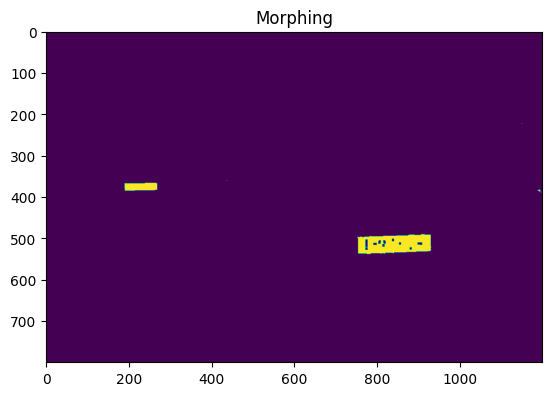

In [7]:
# Close morph
k = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(yellow, cv2.MORPH_CLOSE, k)

plt.imshow(closing)
plt.title('Morphing')

In [8]:
# Detect yellow area
contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [9]:
hierarchy

array([[[11, -1,  1, -1],
        [ 2, -1, -1,  0],
        [ 3,  1, -1,  0],
        [ 4,  2, -1,  0],
        [ 5,  3, -1,  0],
        [ 6,  4, -1,  0],
        [ 7,  5, -1,  0],
        [ 8,  6, -1,  0],
        [ 9,  7, -1,  0],
        [10,  8, -1,  0],
        [-1,  9, -1,  0],
        [12,  0, -1, -1],
        [13, 11, -1, -1],
        [14, 12, -1, -1],
        [15, 13, -1, -1],
        [-1, 14, -1, -1]]], dtype=int32)

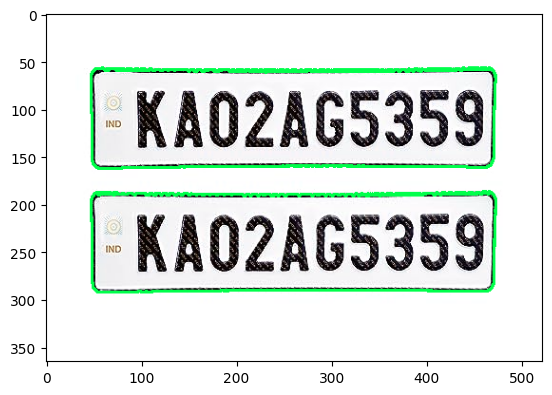

In [10]:
image = cv2.imread('/home/appy1/Downloads/KA02.jpg')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, im = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy  = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(image, contours, -1, (0,255,75), 2)
plt.imshow(img)

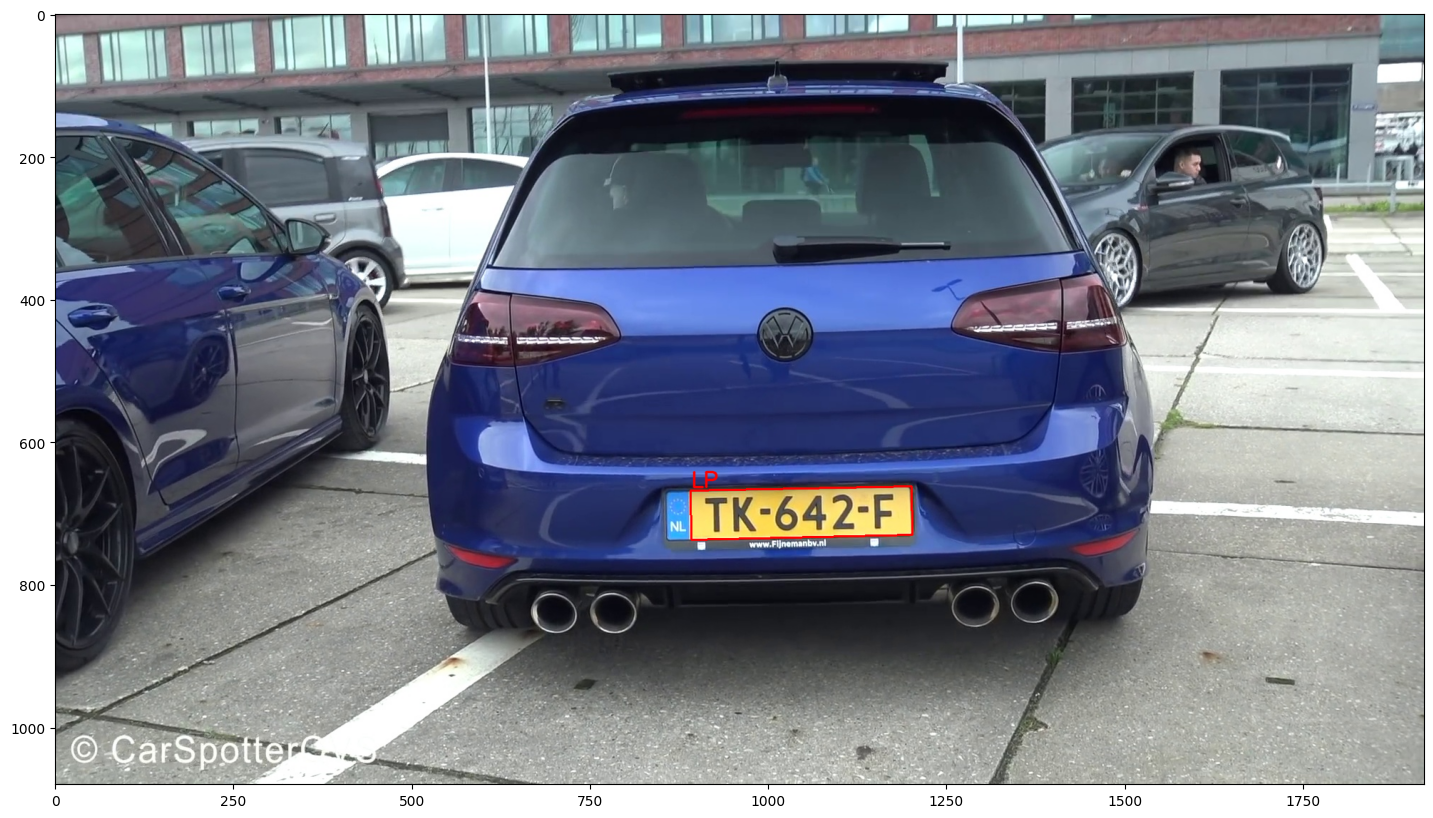

In [25]:
input_image = cv2.imread('/mnt/vol_1/ANPR/Dutch_anpr/data/images/32.jpg')
detection, crops = detect(input_image)
plt.figure(figsize=(25,10))
plt.imshow(cv2.cvtColor(detection, cv2.COLOR_BGR2RGB))
# plt
plt.show()

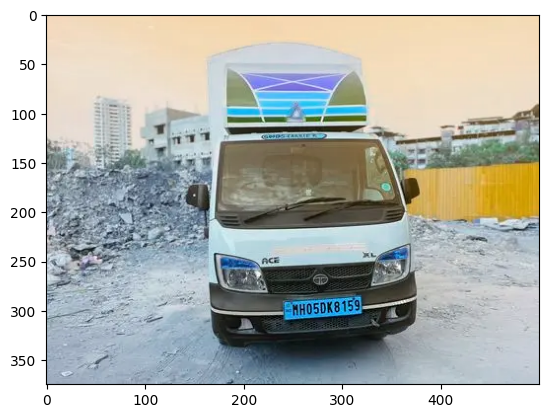

In [27]:
web = cv2.imread('//home/appy1/Downloads/ind100.webp')

plt.imshow(web)

# Convert .webp to .jpg

In [1]:
import glob
import cv2
import os
path = '/home/appy1/Downloads/*.webp'
for i in glob.glob(path):
    img = cv2.imread(i)
    path, ext = i.split('.')
    name = path.split('/')
    print(name[-1])
    
    cv2.imwrite('/mnt/vol_2/Datasets/Number_plate/indian-yellow/'+ name[-1] + '.jpg', img)


ind191
ind157
ind180
ind187
ind198
ind179
ind162
ind196
ind194
ind167
ind145
ind170
ind160
ind163
ind184
ind182
ind50
install_opencv-1804-header
ind169
ind183
ind192
ind178
ind174
ind197
ind161
ind193
ind166
ind168
ind159
ind195
ind200
ind152
ind185
ind172
ind171
ind186
ind188
ind149
25925687-bio-waste-for-compost-earth
ind164
ind146
ind155
ind176
ind173
ind190
ind181
ind148
ind154
ind153
ind177
ind151
ind189
ind156
ind175
ind147
ind165
ind199
ind158
ind144


## Rename and ext change

In [15]:
import glob
import cv2
import os
path = '/mnt/vol_2/Datasets/Number_plate/ind_np_yellow_dataset/imgs/'
files = os.listdir(path)
no = 0
for file in files:
    img = cv2.imread(path + file)
    os.remove(path + file)
    cv2.imwrite(path + 'ind_' + str(no) + '.jpg', img)
    no += 1
    

# Plate detection by yolo

In [21]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path

In [22]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416  #608     #Width of network's input image
inpHeight = 416 #608     #Height of network's input image

In [25]:
classesFile = "/mnt/vol_1/ANPR/Tunisian_anpr/Licence_plate_detection/classes.names";

In [26]:
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [27]:
classes

['LP']

In [28]:
# Give the configuration and weight files for the model and load the network using them.

modelConfiguration = "/mnt/vol_1/ANPR/Tunisian_anpr/Licence_plate_detection/darknet-yolov3.cfg";
modelWeights = "/mnt/vol_1/ANPR/Tunisian_anpr/Licence_plate_detection/lapi.weights";

In [29]:
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)


In [30]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    # return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

## Blob

In [50]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
import matplotlib.pyplot as plt

In [65]:
cap = cv.VideoCapture('/home/appy1/Downloads/tun3.jpg')

In [66]:
# get frame from the video
hasFrame, frame = cap.read()

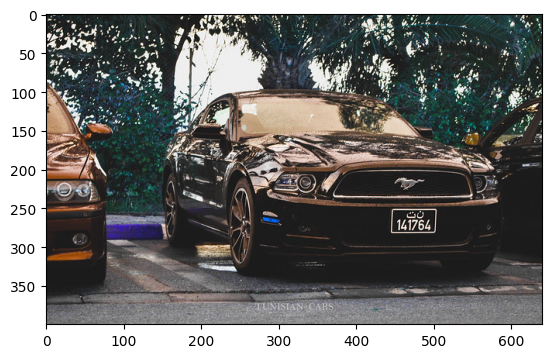

In [67]:
plt.imshow(frame)

In [68]:
inpWidth = 416  #608     #Width of network's input image
inpHeight = 416
# Create a 4D blob from a frame.
blob = cv.dnn.blobFromImage(frame,1/255, (inpWidth, inpHeight), [0, 0, 0], 0, crop=False)
# blob = cv.dnn.blobFromImage(frame)
blob.shape

(1, 3, 416, 416)

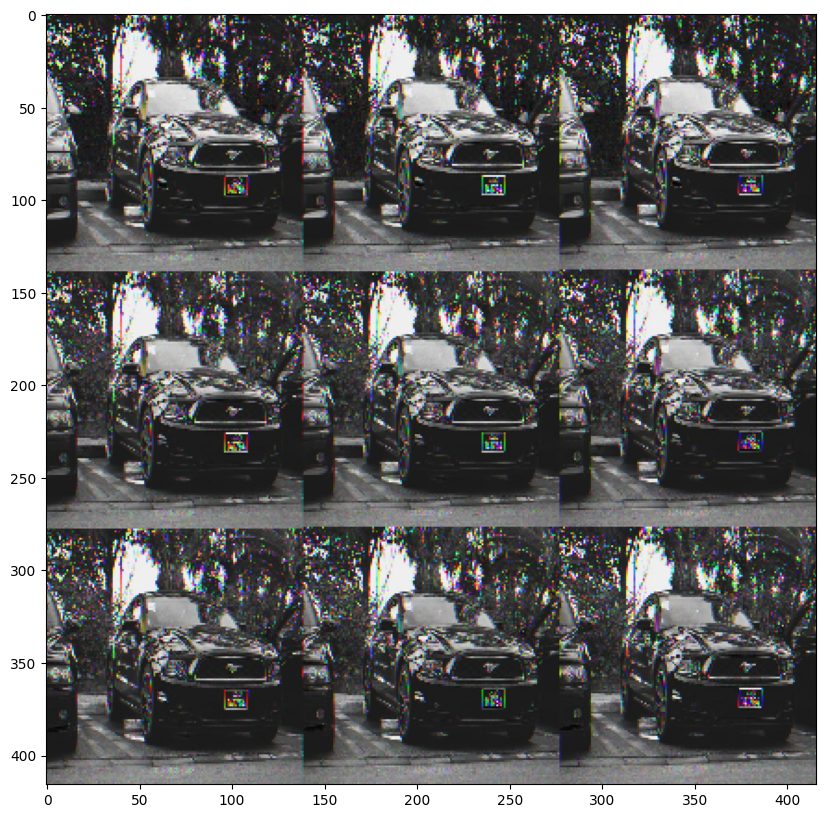

In [69]:
# Reshape the blob to a 3-dimensional array
blob_reshaped = blob.reshape(blob.shape[2], blob.shape[3], blob.shape[1])
# Convert the blob to a valid image format
blob_image = cv.cvtColor(blob_reshaped, cv.COLOR_BGR2RGB)

plt.figure(figsize=(25,10))
plt.imshow(blob_image)

# Pytesseract

Usage:
  tesseract --help | --help-extra | --help-psm | --help-oem | --version
  tesseract --list-langs [--tessdata-dir PATH]
  tesseract --print-parameters [options...] [configfile...]
  tesseract imagename|imagelist|stdin outputbase|stdout [options...] [configfile...]
OCR options:
  --tessdata-dir PATH   Specify the location of tessdata path.
  --user-words PATH     Specify the location of user words file.
  --user-patterns PATH  Specify the location of user patterns file.
  -l LANG[+LANG]        Specify language(s) used for OCR.
  -c VAR=VALUE          Set value for config variables.
                        Multiple -c arguments are allowed.
  --psm NUM             Specify page segmentation mode.
  --oem NUM             Specify OCR Engine mode.
NOTE: These options must occur before any configfile.
Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.
OCR Engine modes: (see https://github.com/tesseract-ocr/tesseract/wiki#linux)
  0    Legacy engine only.
  1    Neural nets LSTM engine only.
  2    Legacy + LSTM engines.
  3    Default, based on what is available.
Single options:
  -h, --help            Show minimal help message.
  --help-extra          Show extra help for advanced users.
  --help-psm            Show page segmentation modes.
  --help-oem            Show OCR Engine modes.
  -v, --version         Show version information.
  --list-langs          List available languages for tesseract engine.
  --print-parameters    Print tesseract parameters.

In [67]:
import pytesseract

def recognise(src_path):
    # custom_config = r'-l eng --psm 6 --dpi 300 --oem 1'
    custom_config = r'-l eng --psm 3 --dpi 300 --oem 1'
    text = pytesseract.image_to_string(src_path, config=custom_config)
    return text
    # with open(out_path, mode='w') as f:
    #     f.write(text)

    # return 0

In [18]:
def post_process(input_file_path):
    f = open(input_file_path, "r")
    text = f.readline()
    puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=',
              '#', '*', '+', '\\', '•', '~', '@', '£',
              '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′',
              'Â', '█', '½', '…',
              '“', '★', '”', '–', '●', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―',
              '¥', '▓', '—', '‹', '─',
              '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '¾',
              'Ã', '⋅', '‘', '∞',
              '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'Ø',
              '¹', '≤', '‡', '√', '«', ' ']

    for punct in puncts:
        if punct in text:
            text = text.replace(punct, '')

    f.close()
    f = open(input_file_path, "w")
    f.write(text)
    f.close()
    return text


In [68]:
def automatic_brightness_and_contrast(image, clip_hist_percent=10):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result, alpha, beta
    
def process(src):

    # Brigthness and contrast adjustment
    adjusted, a, b = automatic_brightness_and_contrast(src)
    # cv2.imwrite("temp/steps/4_Brigthness_contrast_adjustment.png", adjusted)
    # BGR to gray
    gray = cv2.cvtColor(adjusted, cv2.COLOR_BGR2GRAY)
    # cv2.imwrite("temp/steps/5_gray.png", gray)
    # Binary thresh
    #ret, th = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)
    ret, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # cv2.imwrite("temp/steps/6_threshold.png", th)
    return th

' \n\x0c'

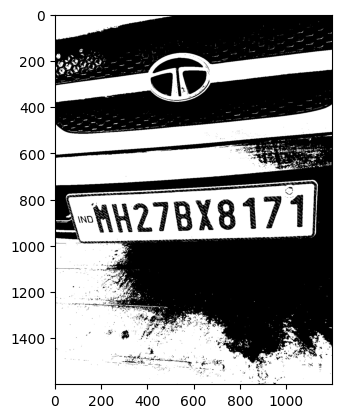

In [69]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/mnt/vol_2/Datasets/Number_plate/Ghanta gadi photo/WhatsApp Image 2024-01-18 at 11.24.20 AM.jpeg')

th = process(img)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(cv2.cvtColor(th, cv2.COLOR_BGR2RGB))
# plt.show()
# threshold = 103
# _, img_binarized = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
# plt.imshow(cv2.cvtColor(img_binarized, cv2.COLOR_BGR2RGB))
# plt.show()
recognise(th)

# Skew Correction

/tmp/ipykernel_49176/632947197.py:7: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


Skew angle: -3


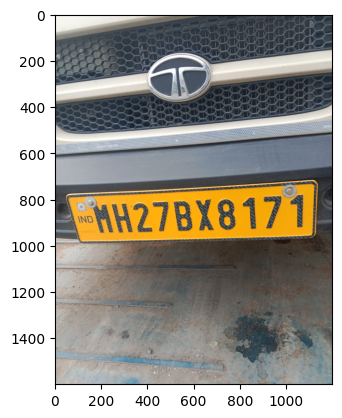

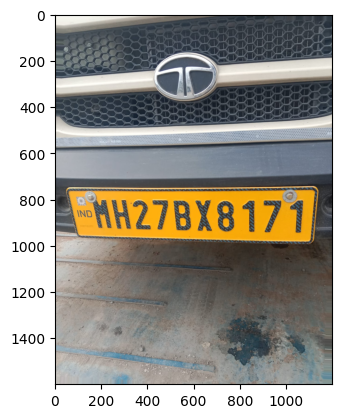

In [60]:
import cv2
import numpy as np
from scipy.ndimage import interpolation as inter

def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

if __name__ == '__main__':
    image = cv2.imread('/mnt/vol_2/Datasets/Number_plate/Ghanta gadi photo/WhatsApp Image 2024-01-18 at 11.24.20 AM.jpeg')
    angle, corrected = correct_skew(image)
    print('Skew angle:', angle)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))
    plt.show()

' \n\n \n\x0c'

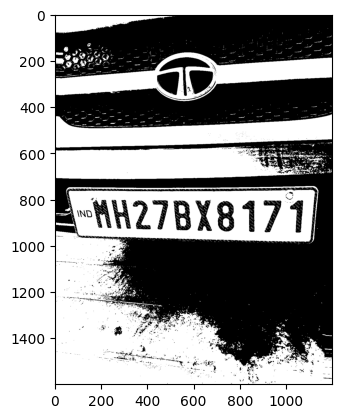

In [70]:
th = process(corrected)
plt.imshow(cv2.cvtColor(th, cv2.COLOR_BGR2RGB))
recognise(th)